In [23]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import matplotlib.font_manager as fm
from textwrap import wrap


prop = fm.FontProperties(fname='../plots/arial.ttf')

plt.rcParams['ps.useafm'] = True
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

from statsmodels.stats.multitest import multipletests

import sys
import os

sys.path.append(os.path.relpath("../../huygens"))
sys.path.append(os.path.relpath("../../galileo"))
import galileo as gal
import huygens as huy

import json

import helper

# Define experiments

In [24]:
with open("experiments.json","r") as f:
    exp = json.load(f)
    
    experiments = exp["experiments"]
    experiment_ids = exp["experiment_ids"]
    display_names = exp["display_names"]
    display_groups = exp["display_groups"]


# Load TPMS and sleuth results

In [25]:
kallisto_sleuth_path = "../data/processed/kallisto_sleuth_merge/"

rpl22_oe_genes = pd.read_hdf(kallisto_sleuth_path + "rpl22_oe_genes.h5", key="sleuth_diff")
rpl22l1_oe_genes = pd.read_hdf(kallisto_sleuth_path + "rpl22l1_oe_genes.h5", key="sleuth_diff")
rpl22l1_kd1_genes = pd.read_hdf(kallisto_sleuth_path + "rpl22l1_kd1_genes.h5", key="sleuth_diff")
rpl22l1_kd2_genes = pd.read_hdf(kallisto_sleuth_path + "rpl22l1_kd2_genes.h5", key="sleuth_diff")
rpl22_a_ko1_genes = pd.read_hdf(kallisto_sleuth_path + "rpl22_a_ko1_genes.h5", key="sleuth_diff")
rpl22_a_ko2_genes = pd.read_hdf(kallisto_sleuth_path + "rpl22_a_ko2_genes.h5", key="sleuth_diff")
rpl22_b_ko1_genes = pd.read_hdf(kallisto_sleuth_path + "rpl22_b_ko1_genes.h5", key="sleuth_diff")
rpl22_b_ko2_genes = pd.read_hdf(kallisto_sleuth_path + "rpl22_b_ko2_genes.h5", key="sleuth_diff")

rpl22_oe_transcripts = pd.read_hdf(kallisto_sleuth_path + "rpl22_oe_transcripts.h5", key="sleuth_diff")
rpl22l1_oe_transcripts = pd.read_hdf(kallisto_sleuth_path + "rpl22l1_oe_transcripts.h5", key="sleuth_diff")
rpl22l1_kd1_transcripts = pd.read_hdf(kallisto_sleuth_path + "rpl22l1_kd1_transcripts.h5", key="sleuth_diff")
rpl22l1_kd2_transcripts = pd.read_hdf(kallisto_sleuth_path + "rpl22l1_kd2_transcripts.h5", key="sleuth_diff")
rpl22_a_ko1_transcripts = pd.read_hdf(kallisto_sleuth_path + "rpl22_a_ko1_transcripts.h5", key="sleuth_diff")
rpl22_a_ko2_transcripts = pd.read_hdf(kallisto_sleuth_path + "rpl22_a_ko2_transcripts.h5", key="sleuth_diff")
rpl22_b_ko1_transcripts = pd.read_hdf(kallisto_sleuth_path + "rpl22_b_ko1_transcripts.h5", key="sleuth_diff")
rpl22_b_ko2_transcripts = pd.read_hdf(kallisto_sleuth_path + "rpl22_b_ko2_transcripts.h5",key="sleuth_diff")

# Differential expression

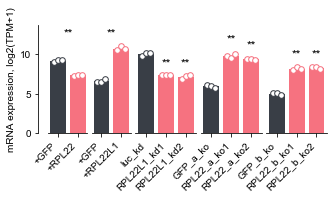

In [25]:
helper.all_bars("ENSG00000163584","gene")

plt.savefig("../plots/RPL22L1_ENSG00000163584_expression.pdf",bbox_inches="tight",background="transparent")

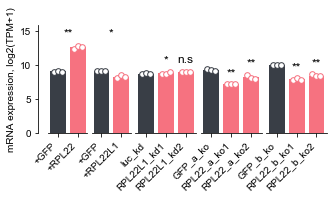

In [28]:
helper.all_bars("ENSG00000116251","gene")

plt.savefig("../plots/RPL22_ENSG00000116251_expression.pdf",bbox_inches="tight",background="transparent")

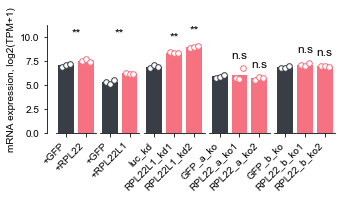

In [29]:
helper.all_bars("ENSG00000135679","gene")

plt.savefig("../plots/MDM2_ENSG00000135679_expression.pdf",bbox_inches="tight",background="transparent")

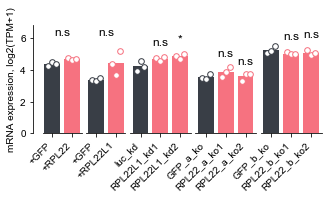

In [30]:
helper.all_bars("ENSG00000198625","gene")

plt.savefig("../plots/MDM4_ENSG00000198625_expression.pdf",bbox_inches="tight",background="transparent")

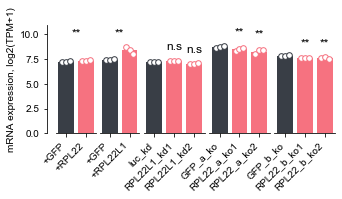

In [31]:
helper.all_bars("ENSG00000143569","gene")

plt.savefig("../plots/UBAP2L_ENSG00000143569_expression.pdf",bbox_inches="tight",background="transparent")

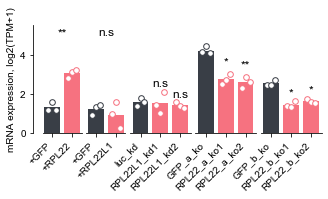

In [32]:
helper.all_bars("ENST00000484819","transcript")

plt.savefig("../plots/UBAP2L_ENST00000484819_expression.pdf",bbox_inches="tight",background="transparent")

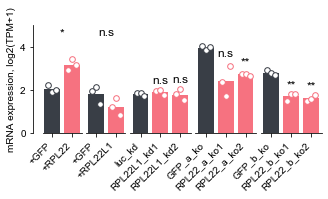

In [33]:
helper.all_bars("ENST00000433615","transcript")

plt.savefig("../plots/UBAP2L_ENST00000433615_expression.pdf",bbox_inches="tight",background="transparent")

## Volcano plots

# Overlaps

In [75]:
def get_gene_overlaps(diffs,cutoff=0.01, direction=None):

    significants = []
    
    for diff in diffs:
        
        if direction == None:
        
            significant = diff.copy(deep=True)[diff["qval"]<cutoff]
            
        if direction == "pos":
            
            significant = diff.copy(deep=True)[diff["qval"]<cutoff]
            significant = significant[significant["treatment_increase"]==1]
            
        elif direction == "neg":
            
            significant = diff.copy(deep=True)[diff["qval"]<cutoff]
            significant = significant[significant["treatment_increase"]==-1]
        
        significant["gene"] = significant["hgnc_gene"].fillna("nan") + "_" + significant["target_id"]
        
        significant_genes = set(significant["gene"])
        
        significants.append(significant_genes)
        
    return list(set.intersection(*significants))

## Between RPL22L1 shRNAs

In [73]:
get_gene_overlaps([rpl22l1_kd1_genes,rpl22l1_kd2_genes])

['FAM69B_138311',
 'ELAVL1_1994',
 'MME_4311',
 'SV2C_22987',
 'GINS2_51659',
 'ENAH_55740',
 'ADAM17_6868',
 'TRIM4_89122',
 'AGR2_10551',
 'ATP5L_10632',
 'HIRA_7290',
 'TMEM245_23731',
 'VANGL1_81839',
 'URM1_81605',
 'TACC3_10460',
 'THRA_7067',
 'RRM2B_50484',
 'TSPAN14_81619',
 'FAM13A_10144',
 'TRIM49C_642612',
 'CSTF2T_23283',
 'SEMA6A_57556',
 'KLHL12_59349',
 'MED28_80306',
 'CTBP1_1487',
 'LNPEP_4012',
 'KIAA0101_9768',
 'H2AFY_9555',
 'TMEM38B_55151',
 'HIP1_3092',
 'EBP_10682',
 'MAN2B2_23324',
 'TUBA1B_10376',
 'FAM114A1_92689',
 'PDIA5_102465667',
 'FNDC3B_101928615',
 'TIAL1_7073',
 'MBP_4155',
 'BLOC1S4_55330',
 'DEPDC1B_55789',
 'NUDT5_11164',
 'SCARA3_51435',
 'GADD45A_1647',
 'MKNK2_2872',
 'RSAD1_55316',
 'ENC1_8507',
 'TBCEL_219899',
 'OTUD3_23252',
 'ENTPD3_956',
 'RPL15_6138',
 'VPS35_55737',
 'ECHS1_1892',
 'SLC25A10_1468',
 'NOB1_28987',
 'IP6K2_51447',
 'ATP2C2_9914',
 'MKLN1_4289',
 'SPAG9_9043',
 'IFRD1_3475',
 'PPFIA2_8499',
 'TBC1D14_57533',
 'NUFIP2_5753

## Between RPL22 sgRNAs

In [60]:
get_gene_overlaps([rpl22_a_ko1_genes,rpl22_a_ko2_genes])

['RPL22_6146', 'RPL22L1_200916', 'UBAP2L_9898']

In [61]:
get_gene_overlaps([rpl22_b_ko1_genes,rpl22_b_ko2_genes])

['CA12_771',
 'EIF1_10209',
 'UBAP2L_9898',
 'TMEM86A_144110',
 'ATP13A5_344905',
 'ESRP1_54845',
 'DUSP4_1846',
 'CLGN_1047',
 'CYP4B1_1580',
 'TMSB4X_7114',
 'ST6GALNAC2_10610',
 'RPL10_26778',
 'RPL22_6146',
 'NACA_4666',
 'IGFBP5_3488',
 'PITX1_5307',
 'RPS14_6208',
 'RPL22L1_200916',
 'STMN3_50861',
 'CLDN3_1365',
 'CTSD_1509',
 'TACR3_6870',
 'FLNA_2316',
 'TMEM87A_25963',
 'RPS27_6232']

In [70]:
get_gene_overlaps([rpl22_a_ko1_genes,rpl22_b_ko1_genes])

['RPL22_6146', 'RPL22L1_200916', 'UBAP2L_9898']

In [71]:
get_gene_overlaps([rpl22_a_ko2_genes,rpl22_b_ko2_genes])

['RPL22_6146', 'RPL22L1_200916', 'UBAP2L_9898']

In [72]:
get_gene_overlaps([rpl22_a_ko1_genes,rpl22_a_ko2_genes,rpl22_b_ko1_genes,rpl22_b_ko2_genes])

['RPL22_6146', 'RPL22L1_200916', 'UBAP2L_9898']

## Between RPL22L1 oe and RPL22L1 shRNAs

In [79]:
get_gene_overlaps([rpl22l1_oe_genes,rpl22l1_kd1_genes, rpl22l1_kd2_genes])

['LLGL1_3996',
 'ZER1_10444',
 'PTRF_284119',
 'UNG_7374',
 'ENAH_55740',
 'TK1_7083',
 'SLC39A7_7922',
 'SCARB2_950',
 'SCD5_79966',
 'MACF1_23499',
 'LAMA5_3911',
 'TRIM4_89122',
 'KRR1_11103',
 'B4GALT5_9334',
 'STT3A_3703',
 'DNAJA1_3301',
 'NGRN_51335',
 'URM1_81605',
 'TACC3_10460',
 'ANP32E_81611',
 'FAM171A1_221061',
 'RRM2B_50484',
 'FAM117B_150864',
 'TSPAN14_81619',
 'TRAF4_9618',
 'CENPBD1P1_65996',
 'MGRN1_23295',
 'PTTG1IP_754',
 'FARP1_10160',
 'RIPK4_54101',
 'NEK9_91754',
 'CTBP1_1487',
 'SEC31A_22872',
 'RB1_5925',
 'DNAJB6_10049',
 'CDC20_991',
 'ESCO2_157570',
 'GFPT1_2673',
 'EBP_10682',
 'HPCAL1_3241',
 'PIDD_55367',
 'EHBP1L1_254102',
 'WDR83OS_51398',
 'MAN2B2_23324',
 'CCDC47_57003',
 'DLGAP4_22839',
 'TUBB_203068',
 'ALKBH5_54890',
 'FAM114A1_92689',
 'PTGFRN_5738',
 'DVL1_1855',
 'SCYL1_57410',
 'LMNA_4000',
 'PDIA5_102465667',
 'HADH_3033',
 'SQRDL_58472',
 'NDUFS1_4719',
 'NDC80_10403',
 'FNDC3B_101928615',
 'SHISA5_51246',
 'FAM208A_23272',
 'TIAL1_7073',


## Between RPL22 oe and RPL22 sgRNAs

In [81]:
get_gene_overlaps([rpl22_oe_genes,rpl22_a_ko1_genes])

['RPL22_6146', 'RPL22L1_200916', 'UBAP2L_9898']

In [82]:
get_gene_overlaps([rpl22_oe_genes,rpl22_a_ko2_genes])

['RPL22_6146', 'RPL22L1_200916', 'UBAP2L_9898']

In [85]:
get_gene_overlaps([rpl22_oe_genes,rpl22_a_ko1_genes,rpl22_a_ko2_genes])

['RPL22_6146', 'RPL22L1_200916', 'UBAP2L_9898']

In [83]:
get_gene_overlaps([rpl22_oe_genes,rpl22_b_ko1_genes])

['RPL22_6146',
 'RPL22L1_200916',
 'PODXL2_50512',
 'APP_351',
 'UBAP2L_9898',
 'ST6GALNAC2_10610',
 'RPS14_6208',
 'RPL10_26778',
 'FAM83H_286077',
 'DUSP4_1846',
 'AR_367']

In [84]:
get_gene_overlaps([rpl22_oe_genes,rpl22_b_ko2_genes])

['GPR107_57720',
 'YKT6_10652',
 'UBAP2L_9898',
 'RPL3_116938',
 'FASN_2194',
 'SLC39A7_7922',
 'RPL7_6129',
 'DUSP4_1846',
 'nan_10381',
 'AGR2_10551',
 'PSD3_23362',
 'LGALS8_3964',
 'ST6GALNAC2_10610',
 'ACBD3_64746',
 'RPL10_26778',
 'PPP1R15B_84919',
 'CMBL_134147',
 'EEF1A1_1915',
 'ACSL1_2180',
 'RPL22_6146',
 'RPS25_6230',
 'RPS24_6229',
 'SQSTM1_8878',
 'EIF4B_1975',
 'GAPDH_2597',
 'RPS14_6208',
 'NEU1_4758',
 'HSPB8_26353',
 'RHOBTB3_22836',
 'RPL15_6138',
 'GOLGA5_9950',
 'RPL21P75_100131205',
 'RPL22L1_200916',
 'PEG10_23089',
 'EIF3L_51386',
 'NQO1_1728',
 'PABPC1_26986',
 'SNX9_51429',
 'SF3A1_10291',
 'BTF3_689',
 'RPL14_9045']

In [86]:
get_gene_overlaps([rpl22_oe_genes,rpl22_b_ko1_genes,rpl22_b_ko2_genes])

['RPL22_6146',
 'RPL22L1_200916',
 'UBAP2L_9898',
 'ST6GALNAC2_10610',
 'RPS14_6208',
 'RPL10_26778',
 'DUSP4_1846']

In [87]:
get_gene_overlaps([rpl22_oe_genes,rpl22_a_ko1_genes,rpl22_a_ko2_genes,rpl22_b_ko1_genes,rpl22_b_ko2_genes])

['RPL22_6146', 'RPL22L1_200916', 'UBAP2L_9898']

## Between RPL22L1 oe and RPL22 oe

In [88]:
get_gene_overlaps([rpl22_oe_genes,rpl22l1_oe_genes])

['SAFB2_9667',
 'SLC39A7_7922',
 'NGRN_51335',
 'ABHD17A_81926',
 'PDIA4_9601',
 'RPL13A_26819',
 'MTF1_4520',
 'PARP2_10038',
 'EBP_10682',
 'C8orf4_56892',
 'ALKBH5_54890',
 'LMNA_4000',
 'PHB2_11331',
 'HEBP2_23593',
 'SMCR8_140775',
 'RER1_11079',
 'SLC25A6_293',
 'nan_10381',
 'SLC4A1AP_22950',
 'YBX3_8531',
 'PREP_5550',
 'TBL1XR1_79718',
 'PANK3_79646',
 'WHAMM_123720',
 'KMT2A_4297',
 'TNPO3_23534',
 'PA2G4_5036',
 'SBDS_51119',
 'ZYX_7791',
 'RPS25_6230',
 'WWC3_55841',
 'RPL15_6138',
 'RPL22L1_200916',
 'SLC25A10_1468',
 'KLF6_1316',
 'BAZ1B_9031',
 'UBAP2L_9898',
 'TAF3_83860',
 'ELF1_1997',
 'CKB_1152',
 'PPP1R10_5514',
 'RUVBL1_8607',
 'RPL35A_6165',
 'RPS19_6223',
 'EP300_2033',
 'SUMF2_25870',
 'BAZ2A_11176',
 'JOSD1_9929',
 'RPL31_6160',
 'TMED9_54732',
 'SOX4_6659',
 'SEC24A_10802',
 'SEMA3C_10512',
 'COL6A1_1291',
 'CCDC50_152137',
 'KCTD5_54442',
 'GAS6_2621',
 'SMAD1_4086',
 'PSAP_5660',
 'MTMR6_9107',
 'RPS14_6208',
 'SERPINB5_5268',
 'GNB2L1_619571',
 'AHNAK_79026

# fgsea results

In [18]:
rpl22_oe_fgsea = pd.read_csv("../data/processed/fgsea_results/rpl22_oe.txt",sep="\t",index_col=0)
rpl22l1_oe_fgsea = pd.read_csv("../data/processed/fgsea_results/rpl22l1_oe.txt",sep="\t",index_col=0)
rpl22l1_kd1_fgsea = pd.read_csv("../data/processed/fgsea_results/rpl22l1_kd1.txt",sep="\t",index_col=0)
rpl22l1_kd2_fgsea = pd.read_csv("../data/processed/fgsea_results/rpl22l1_kd2.txt",sep="\t",index_col=0)
rpl22_a_ko1_fgsea = pd.read_csv("../data/processed/fgsea_results/rpl22_a_ko1.txt",sep="\t",index_col=0)
rpl22_a_ko2_fgsea = pd.read_csv("../data/processed/fgsea_results/rpl22_a_ko2.txt",sep="\t",index_col=0)
rpl22_b_ko1_fgsea = pd.read_csv("../data/processed/fgsea_results/rpl22_b_ko1.txt",sep="\t",index_col=0)
rpl22_b_ko2_fgsea = pd.read_csv("../data/processed/fgsea_results/rpl22_b_ko2.txt",sep="\t",index_col=0)

def preprocess_fgsea(fgsea):
    fgsea.sort_values(by="padj",inplace=True)
    fgsea.index = fgsea["pathway"]
    fgsea["gene_set"] = fgsea["pathway"].str.split("_").str[0]
    fgsea["direction"] = fgsea["NES"] > 0
    
preprocess_fgsea(rpl22_oe_fgsea)
preprocess_fgsea(rpl22l1_oe_fgsea)
preprocess_fgsea(rpl22l1_kd1_fgsea)
preprocess_fgsea(rpl22l1_kd2_fgsea)
preprocess_fgsea(rpl22_a_ko1_fgsea)
preprocess_fgsea(rpl22_a_ko2_fgsea)
preprocess_fgsea(rpl22_b_ko1_fgsea)
preprocess_fgsea(rpl22_b_ko2_fgsea)


In [19]:
def get_top_n(fgsea, n=4):
#     positives = fgsea[fgsea["direction"]==True].head(n)
#     negatives = fgsea[fgsea["direction"]==False].head(n)

    return fgsea.head(n*2)
    
#     return pd.concat([positives,negatives],axis=0).sort_values(by="pval")

rpl22_oe_fgsea_top = get_top_n(rpl22_oe_fgsea)
rpl22l1_oe_fgsea_top = get_top_n(rpl22l1_oe_fgsea)
rpl22l1_kd1_fgsea_top = get_top_n(rpl22l1_kd1_fgsea)
rpl22l1_kd2_fgsea_top = get_top_n(rpl22l1_kd2_fgsea)
rpl22_a_ko1_fgsea_top = get_top_n(rpl22_a_ko1_fgsea)
rpl22_a_ko2_fgsea_top = get_top_n(rpl22_a_ko2_fgsea)
rpl22_b_ko1_fgsea_top = get_top_n(rpl22_b_ko1_fgsea)
rpl22_b_ko2_fgsea_top = get_top_n(rpl22_b_ko2_fgsea)

In [20]:
fgsea = rpl22l1_oe_fgsea_top


def plot_top(fgsea_top, ax=None, legend=False):

    if ax is None:

        ax = plt.subplot(111)

    g = sns.scatterplot(
        -np.log10(fgsea_top["padj"]),
        np.arange(8),
        size=fgsea_top["size"].rename("Gene set size"),
        hue=(fgsea_top["NES"] > 0).replace(
            {True: "Upregulated", False: "Downregulated"}).rename("Expression change,\ntreatment"),
        sizes=(40, 250),
        size_norm=(0, 500),
        palette={"Upregulated": "#3f72af", "Downregulated": "#e23e57"},
        ax=ax,
        legend=legend
    )
    
    if legend:
        g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)   

    ax.set_xlim(0, plt.xlim()[1]*1.1)


    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    ax.spines['bottom'].set_position(('axes', -0.025))
    ax.spines['left'].set_position(('axes', -0.05))

    ax.set_xlabel("-log10(q-value)")
    ax.set_yticks(np.arange(8))
    
    ylabels = fgsea_top["pathway"].apply(
        lambda x: x.replace("_", " ").capitalize())
    
    ylabels = ylabels.apply(lambda x: x.replace("Go ","").replace(" process","").capitalize())
    
    ax.set_yticklabels(ylabels)

    return ax

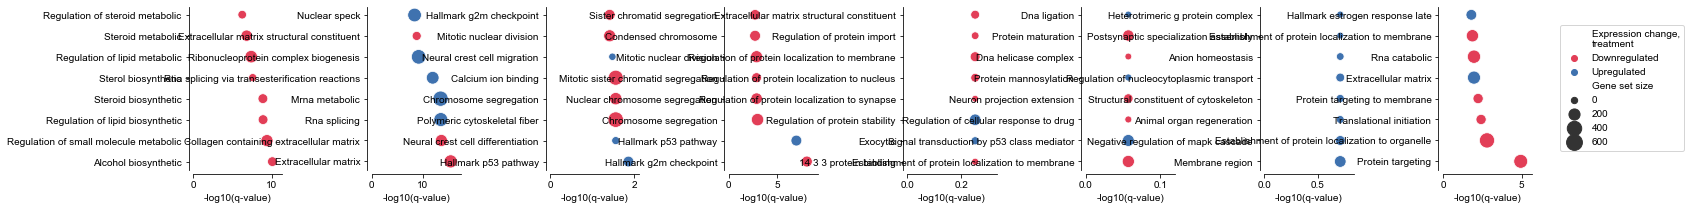

In [21]:
plt.figure(figsize=(24,3))
plot_top(rpl22_oe_fgsea_top,plt.subplot(181))
plot_top(rpl22l1_oe_fgsea_top,plt.subplot(182))
plot_top(rpl22l1_kd1_fgsea_top,plt.subplot(183))
plot_top(rpl22l1_kd2_fgsea_top,plt.subplot(184))
plot_top(rpl22_a_ko1_fgsea_top,plt.subplot(185))
plot_top(rpl22_a_ko2_fgsea_top,plt.subplot(186))
plot_top(rpl22_b_ko1_fgsea_top,plt.subplot(187))
plot_top(rpl22_b_ko2_fgsea_top,plt.subplot(188),legend='brief')


plt.subplots_adjust(wspace=1)

# plt.savefig("../plots/fgsea_top.pdf",bbox_inches="tight",background="transparent")